In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime

In [3]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Load processed data
path = '../../data/processed/merged_mbta_weather.csv'
df = pd.read_csv(path)

# Convert service_date to datetime for time-based analysis
df['service_date'] = pd.to_datetime(df['service_date'])

In [4]:
# Feature Engineering
# Add day of week (0 = Monday, 6 = Sunday)
df['day_of_week'] = df['service_date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['month'] = df['service_date'].dt.month
df['year'] = df['service_date'].dt.year

# COVID-19 related features
df['is_covid_period'] = (df['service_date'] >= '2020-03-15').astype(int)
df['is_recovery_period'] = ((df['service_date'] >= '2021-03-01') & 
                           (df['service_date'] < '2022-01-01')).astype(int)
df['is_post_covid'] = (df['service_date'] >= '2022-01-01').astype(int)

# Add recovery phase variable (linear ramp-up after vaccines)
df['recovery_phase'] = 0
recovery_start = pd.Timestamp('2021-03-01')
recovery_mask = df['service_date'] >= recovery_start
days_since_recovery = (df.loc[recovery_mask, 'service_date'] - recovery_start).dt.days
max_days = days_since_recovery.max() if len(days_since_recovery) > 0 else 1  # Avoid division by zero
df.loc[recovery_mask, 'recovery_phase'] = days_since_recovery / max_days

/var/folders/td/336js9nx5gs4l3sd3xhz6wxw0000gn/T/ipykernel_1849/4143294496.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0. 0. 0. ... 1. 1. 1.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[recovery_mask, 'recovery_phase'] = days_since_recovery / max_days


In [5]:
# Define MBTA line colors and their stations (same as in sortedByLine.ipynb)
line_colors = {
    'Red': ['Alewife', 'Davis', 'Porter', 'Harvard', 'Central', 'Kendall', 'Charles/MGH', 'Park Street', 
            'Downtown Crossing', 'South Station', 'Broadway', 'Andrew', 'JFK/UMass', 'Savin Hill',
            'Fields Corner', 'Shawmut', 'Ashmont', 'North Quincy', 'Wollaston', 'Quincy Center', 
            'Quincy Adams', 'Braintree'],
    'Green': ['Lechmere', 'Science Park', 'North Station', 'Haymarket', 'Government Center', 
              'Park Street', 'Boylston', 'Arlington', 'Copley', 'Hynes', 'Kenmore', 'Prudential',
              'Symphony', 'Northeastern', 'Museum of Fine Arts', 'Longwood Medical Area', 'Brigham Circle',
              'Fenwood Road', 'Mission Park', 'Riverway', 'Back of the Hill', 'Heath Street', 'Cleveland Circle',
              'Beaconsfield', 'Reservoir', 'Chestnut Hill', 'Newton Centre', 'Boston College'],
    'Orange': ['Oak Grove', 'Malden Center', 'Wellington', 'Assembly', 'Sullivan Square', 'Community College',
              'North Station', 'Haymarket', 'State', 'Downtown Crossing', 'Chinatown', 'Tufts Medical Center',
              'Back Bay', 'Massachusetts Avenue', 'Ruggles', 'Roxbury Crossing', 'Jackson Square',
              'Stony Brook', 'Green Street', 'Forest Hills'],
    'Blue': ['Wonderland', 'Revere Beach', 'Beachmont', 'Suffolk Downs', 'Orient Heights', 'Wood Island',
            'Airport', 'Maverick', 'Aquarium', 'State', 'Government Center', 'Bowdoin'],
    'Silver': ['South Station', 'Courthouse', 'World Trade Center']
}

# Add line color based on station names
def assign_line_colors(df, line_colors):
    """Assign MBTA line colors to stations in the dataframe"""
    df['line_color'] = 'Other'  # Default value
    for color, stations in line_colors.items():
        for station in stations:
            mask = df['station_name'].str.contains(station, case=False, na=False)
            df.loc[mask, 'line_color'] = color
    return df

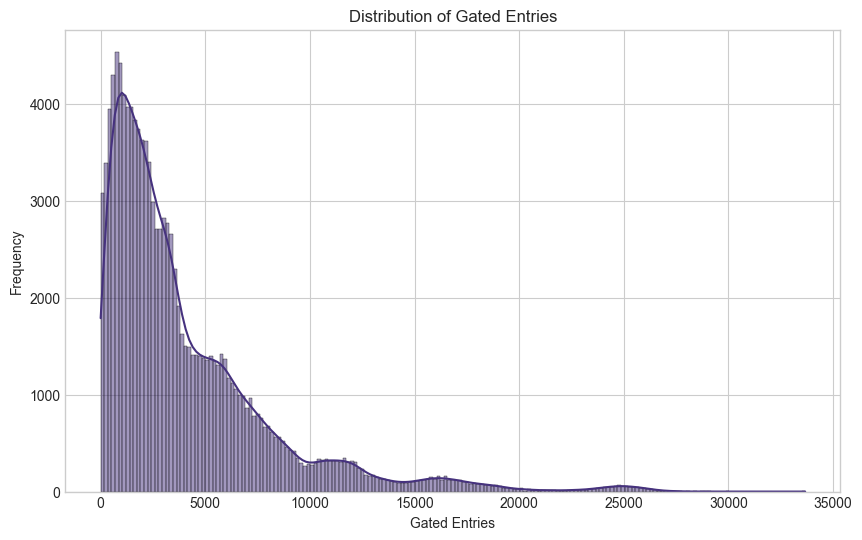

In [6]:
# Assign line colors
df = assign_line_colors(df, line_colors)

# Visualize the distribution of entries
plt.figure(figsize=(10, 6))
sns.histplot(df['gated_entries'], kde=True)
plt.title('Distribution of Gated Entries')
plt.xlabel('Gated Entries')
plt.ylabel('Frequency')
plt.show()

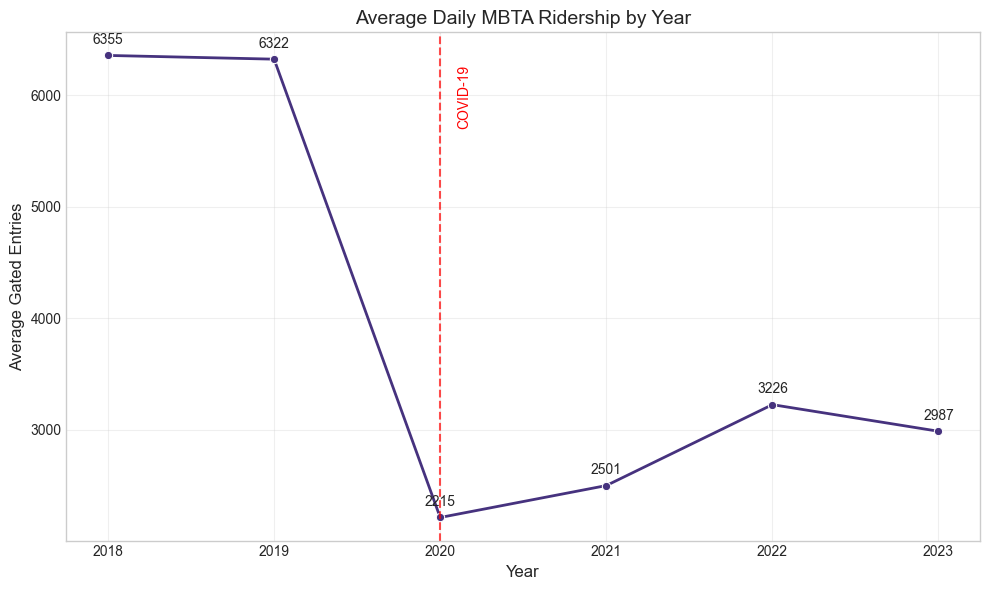

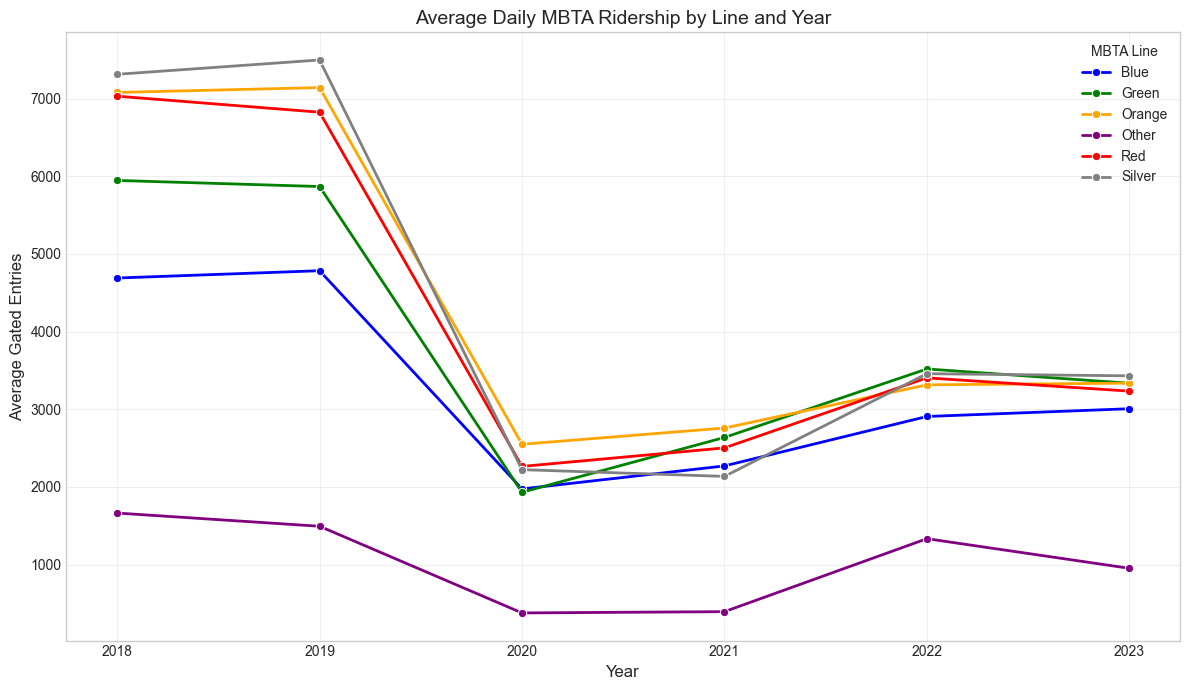

In [7]:
# Analyzing ridership trends across years
yearly_ridership = df.groupby('year')['gated_entries'].mean().reset_index()

# Create the yearly ridership chart
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='gated_entries', data=yearly_ridership, marker='o', linewidth=2)
plt.title('Average Daily MBTA Ridership by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Gated Entries', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(yearly_ridership['year'])

# Add text labels for each point
for x, y in zip(yearly_ridership['year'], yearly_ridership['gated_entries']):
  plt.text(x, y + 100, f'{y:.0f}', ha='center')

# Add annotations for major events
plt.axvline(x=2020, color='red', linestyle='--', alpha=0.7)
plt.text(2020.1, yearly_ridership['gated_entries'].max()*0.9, 'COVID-19', 
     rotation=90, color='red', fontsize=10)

plt.tight_layout()
plt.show()

# Let's also analyze ridership by line color across years
line_year_ridership = df.groupby(['year', 'line_color'])['gated_entries'].mean().reset_index()

# Define the color palette matching MBTA lines
mbta_palette = {
  'Red': 'red',
  'Green': 'green',
  'Orange': 'orange',
  'Blue': 'blue',
  'Silver': 'grey',
  'Other': 'purple'
}

plt.figure(figsize=(12, 7))
sns.lineplot(x='year', y='gated_entries', hue='line_color', data=line_year_ridership,
       marker='o', linewidth=2, palette=mbta_palette) # Use the defined palette
plt.title('Average Daily MBTA Ridership by Line and Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Gated Entries', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(line_year_ridership['year'].unique())
plt.legend(title='MBTA Line')

plt.tight_layout()
plt.show()

# Explore correlations between weather and ridership


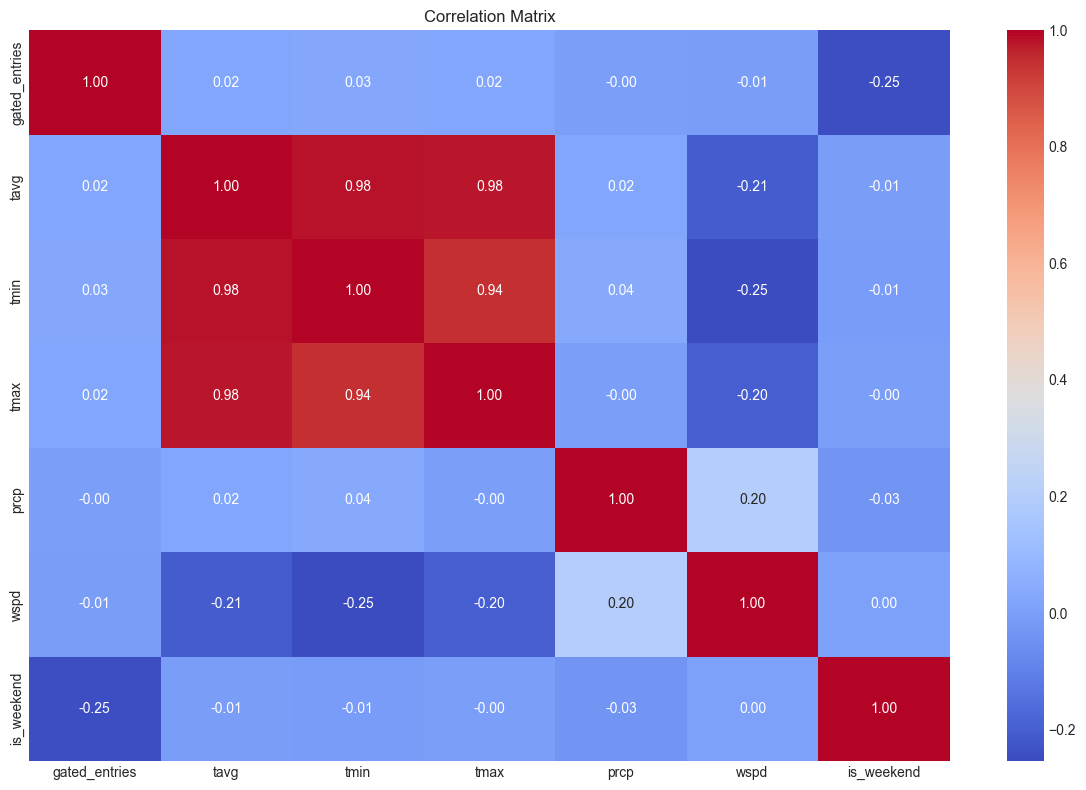

In [8]:
plt.figure(figsize=(12, 8))
correlation_vars = ['gated_entries', 'tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'is_weekend']
correlation_matrix = df[correlation_vars].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Scatter plots for each weather variable


/var/folders/td/336js9nx5gs4l3sd3xhz6wxw0000gn/T/ipykernel_1849/1240793095.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


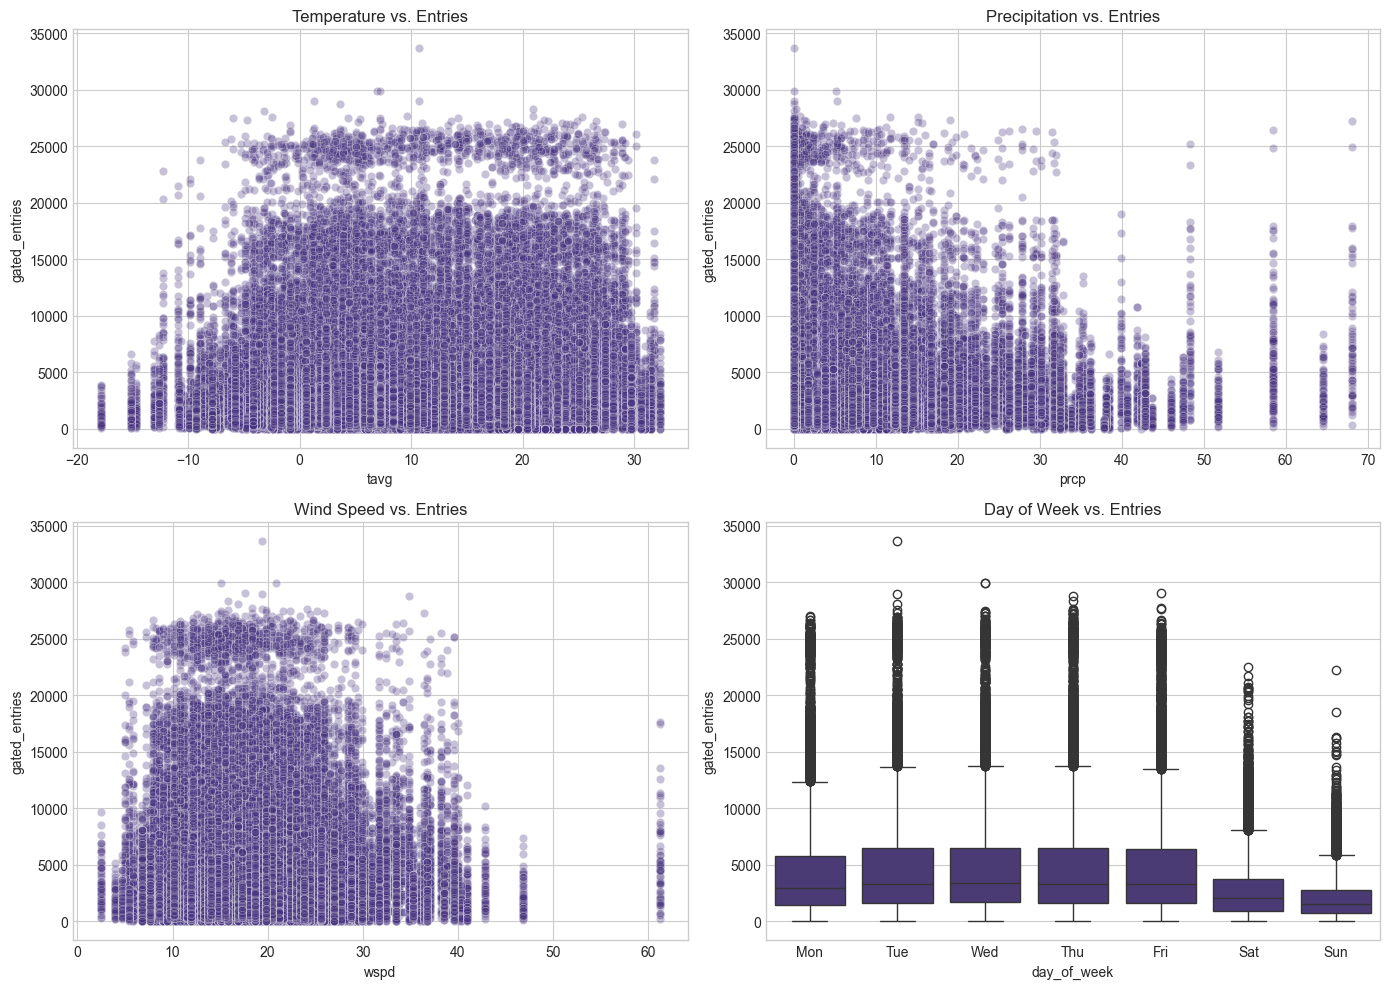

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.scatterplot(x='tavg', y='gated_entries', data=df, alpha=0.3, ax=axes[0, 0])
axes[0, 0].set_title('Temperature vs. Entries')

sns.scatterplot(x='prcp', y='gated_entries', data=df, alpha=0.3, ax=axes[0, 1])
axes[0, 1].set_title('Precipitation vs. Entries')

sns.scatterplot(x='wspd', y='gated_entries', data=df, alpha=0.3, ax=axes[1, 0])
axes[1, 0].set_title('Wind Speed vs. Entries')

sns.boxplot(x='day_of_week', y='gated_entries', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Day of Week vs. Entries')
axes[1, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.tight_layout()
plt.show()

# Linear Regression Modeling


In [10]:
# 1. Basic model using only weather variables
print("\n--- Basic Linear Regression Model ---")

# Select features and target
weather_features = ['tavg', 'prcp', 'wspd']
X = df[weather_features]
y = df['gated_entries']

# Train-test split based on time
# Train on data before 2022, test on 2022-2023 data
train_mask = df['service_date'] < '2022-01-01'
test_mask = df['service_date'] >= '2022-01-01'

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


--- Basic Linear Regression Model ---
Training set size: 91121 samples
Testing set size: 27771 samples


In [11]:
# Evaluate the basic model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Display coefficients
coef_df = pd.DataFrame({
    'Feature': weather_features,
    'Coefficient': model.coef_,
})
print("\nModel Coefficients:")
print(coef_df)
print(f"Intercept: {model.intercept_:.2f}")

Mean Squared Error (MSE): 7575075.58
Root Mean Squared Error (RMSE): 2752.29
Mean Absolute Error (MAE): 2380.66
R² Score: -0.2221

Model Coefficients:
  Feature  Coefficient
0    tavg     1.973302
1    prcp    -6.309341
2    wspd     3.616571
Intercept: 4293.10


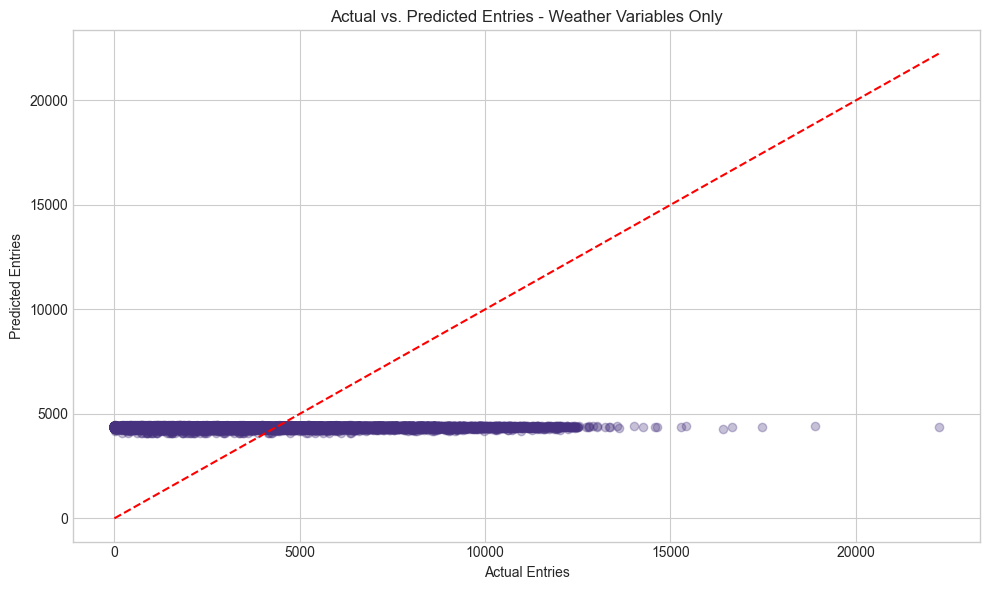

In [12]:
# Visualize actual vs. predicted for basic model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Entries')
plt.ylabel('Predicted Entries')
plt.title('Actual vs. Predicted Entries - Weather Variables Only')
plt.tight_layout()
plt.show()

In [13]:
# 2. Enhanced model with weather + time features
print("\n--- Enhanced Linear Regression Model ---")

# Add additional features (one-hot encoding day of week and month)
df_encoded = pd.get_dummies(df, columns=['day_of_week', 'month', 'line_color'], drop_first=True)

# Select features and target
enhanced_features = [col for col in df_encoded.columns if col.startswith(('tavg', 'prcp', 'wspd', 
                                                                         'day_of_week_', 'month_', 
                                                                         'line_color_', 'is_weekend'))] 
enhanced_features.extend(['is_covid_period', 'is_recovery_period', 'is_post_covid', 'recovery_phase'])

# Add interaction terms between weather and COVID periods
df_encoded['tavg_covid'] = df_encoded['tavg'] * df_encoded['is_covid_period']
df_encoded['prcp_covid'] = df_encoded['prcp'] * df_encoded['is_covid_period']
df_encoded['wspd_covid'] = df_encoded['wspd'] * df_encoded['is_covid_period']
enhanced_features.extend(['tavg_covid', 'prcp_covid', 'wspd_covid'])

X_enhanced = df_encoded[enhanced_features]
y = df_encoded['gated_entries']


--- Enhanced Linear Regression Model ---


In [14]:
# Train-test split based on time
train_mask = df_encoded['service_date'] < '2022-01-01'
test_mask = df_encoded['service_date'] >= '2022-01-01'

X_train_enhanced = X_enhanced[train_mask]
X_test_enhanced = X_enhanced[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

# Train the enhanced model
enhanced_model = LinearRegression()
enhanced_model.fit(X_train_enhanced, y_train)

# Make predictions
y_pred_enhanced = enhanced_model.predict(X_test_enhanced)

# Evaluate the model
mse_enhanced = mean_squared_error(y_test, y_pred_enhanced)
rmse_enhanced = np.sqrt(mse_enhanced)
mae_enhanced = mean_absolute_error(y_test, y_pred_enhanced)
r2_enhanced = r2_score(y_test, y_pred_enhanced)

print(f"Mean Squared Error (MSE): {mse_enhanced:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_enhanced:.2f}")
print(f"Mean Absolute Error (MAE): {mae_enhanced:.2f}")
print(f"R² Score: {r2_enhanced:.4f}")

Mean Squared Error (MSE): 6897803.55
Root Mean Squared Error (RMSE): 2626.37
Mean Absolute Error (MAE): 2173.87
R² Score: -0.1129


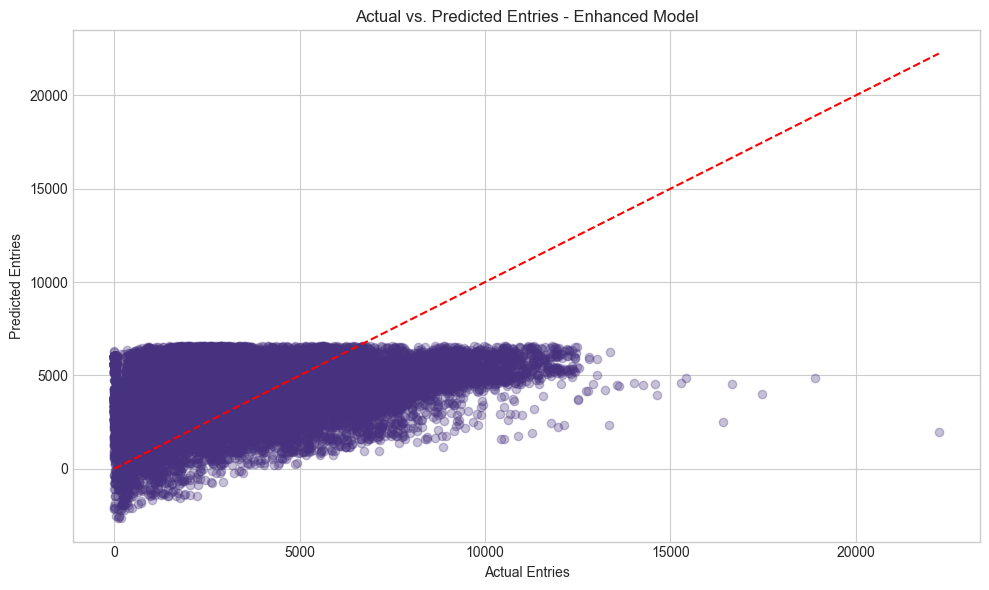

In [15]:
# Visualize actual vs. predicted for enhanced model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_enhanced, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Entries')
plt.ylabel('Predicted Entries')
plt.title('Actual vs. Predicted Entries - Enhanced Model')
plt.tight_layout()
plt.show()

# Create variables to store model metrics for later comparison
models = ['Weather Variables Only', 'Enhanced Model']
r2_scores = [r2, r2_enhanced]
rmse_scores = [rmse, rmse_enhanced]

In [16]:
# Top influential features
coef_df_enhanced = pd.DataFrame({
    'Feature': enhanced_features,
    'Coefficient': enhanced_model.coef_,
})
coef_df_enhanced = coef_df_enhanced.sort_values('Coefficient', key=abs, ascending=False)
print("\nTop 10 Influential Features:")
print(coef_df_enhanced.head(10))


Top 10 Influential Features:
              Feature   Coefficient
9       day_of_week_6 -1.992135e+14
8       day_of_week_5 -1.992135e+14
3          is_weekend  1.992135e+14
26    is_covid_period -5.049520e+03
29     recovery_phase  3.695478e+03
23   line_color_Other -2.435199e+03
22  line_color_Orange  1.455788e+03
25  line_color_Silver  1.367821e+03
24     line_color_Red  1.215331e+03
18           month_10  7.694632e+02
